# PCA and clustering analysis of 5G RNA-seq 
The initial notebook started exploring various dimensions of the 5G RNA-seq data (78 experiments). In particular, it uses PCA and LDA to examine how the genes relate to one another as well as how the experiments relate in reduced dimensions. 


This is a duplicated notebook that will now use the data after it has been grouped into experimental conditions

In [1]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from override import GENE_NAME_OVERRIDE, GENE_PRODUCT_OVERRIDE, SYS_LOOKUP



## Load TPM data
Load gene expression data - experiements have already been grouped into conditions and gene TPMs are an average across all genes which have been in that experiment.

In [2]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/sample2condition.txt'

# load TPM data
df = pd.read_csv(tpm_data_file,sep='\t').fillna('')

    
# load mapping from sample to condition
with open(sample2condition_file,'r') as f:
    sample2condition = dict(x.strip().split() for x in f.readlines())

df.head()

locus_tag                                         product type  \
0  EQU24_RS00005  chromosomal replication initiator protein DnaA  CDS   
1  EQU24_RS00010                 DNA polymerase III subunit beta  CDS   
2  EQU24_RS00015             DNA replication/repair protein RecF  CDS   
3  EQU24_RS00020   DNA topoisomerase (ATP-hydrolyzing) subunit B  CDS   
4  EQU24_RS00025                            hypothetical protein  CDS   

  gene_symbol          locus  start_coord  end_coord  \
0        dnaA  NZ_CP035467.1            0       1317   
1              NZ_CP035467.1         1502       2603   
2        recF  NZ_CP035467.1         3060       4140   
3        gyrB  NZ_CP035467.1         4185       6600   
4              NZ_CP035467.1         6825       7062   

                                                note  \
0  Derived by automated computational analysis us...   
1  Derived by automated computational analysis us...   
2  Derived by automated computational analysis us...   
3  Derived by automated computational analysis us...   
4  Derived by automated computational analysis us...   

                                         translation  gene_len  ...  \
0  MSALWNNCLAKLENEISSSEFSTWIRPLQAIETDGQIKLLAPNRFV...      1318  ...   
1  MKYIINREQLLVPLQQIVSVIEKRQTMPILSNVLMVFRENTLVMTG...      1102  ...   
2  MSLQKLDIFNVRNIRQASLQPSPGLNLIYGANASGKSSVLEAIFIL...      1081  ...   
3  MSENIKQYDSTNIQVLKGLDAVRKRPGMYIGDTDDGTGLHHMVFEV...      2416  ...   
4  VKTTKYFLTTRMRPDREIIKDEWIQYVVRFPENEHIQFDGRIRRWA...       238  ...   

   5GB1_pA9_red_tpm  5GB1_pA9_yellow_tpm  5GB1C-5G-La-BR1_tpm  \
0         38.557373            38.810668            37.444214   
1         52.552767            52.461746            42.676553   
2         31.350991            34.914128            21.479309   
3         74.848501            80.850761            54.959319   
4         50.324948            49.349547            34.539657   

   5GB1C-5G-La-BR2_tpm  5GB1C-5G-N-BR1_tpm  5GB1C-5G-N-BR2_tpm  \
0            40.246006           40.100118           33.432274   
1            49.210083           46.798476           48.142385   
2            24.204682           22.171104           22.006566   
3            64.911376           59.653059           64.648318   
4            36.521074           37.789611           39.358066   

   5GB1C-JG15-La-BR1_tpm  5GB1C-JG15-La-BR2_tpm  5GB1C-JG15-N-BR1_tpm  \
0              39.880174              38.355431             30.247582   
1              45.465136              46.498139             37.152951   
2              22.658157              22.753325             19.407103   
3              69.119079              65.643179             57.590223   
4              38.992158              35.870964             41.462392   

   5GB1C-JG15-N-BR2_tpm  
0             41.248441  
1             52.902410  
2             29.834124  
3             68.306759  
4             40.227192  

[5 rows x 108 columns]

### We may want to reassociate meta data with loci later. Save that here in `locus2info` dict

In [3]:
def make_info_dict(row):
    d = {
        'gene':row[1],
        'product':row[2],
        'type':row[3],
    }
    return d

info = df[['locus_tag','gene_symbol','product','type']].values
locus2info = dict(
    [(row[0],make_info_dict(row)) for row in info]
)

In [4]:
locus2info['EQU24_RS19315']

{'gene': '',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [5]:
# add some manually overridden gene names

for loc in GENE_NAME_OVERRIDE:
    locus2info[loc]['gene'] = GENE_NAME_OVERRIDE[loc]
for loc in GENE_PRODUCT_OVERRIDE:
    locus2info[loc]['product'] = GENE_PRODUCT_OVERRIDE[loc]

In [6]:
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [7]:
# mdf = pd.read_csv("data/mean_df_for_parCoords.tsv",sep='\t').fillna("")
# list_ordering = ['uMax','lowCH4','NoCu','lowCu','medCu','highCu','NO3_lowO2_slow_growth','highO2_slow_growth','lowO2_fast_growth','MeOH','NoLanthanum','WithLanthanum'] 
# mdf["exp_condition_order"] = pd.Categorical(mdf["exp_condition"], categories=list_ordering)

# # this is used later to rebuild dfs
# locus2type = dict(mdf[['locus_tag','type']].values)

In [8]:
#mdf.head()

In [9]:
# # load genbank too
# import genbank_utils as gu
# from Bio import SeqIO, SeqFeature

# gbFile_5G = 'data/genome/5GB1c_sequence.gb'
# gb_5G = SeqIO.parse(gbFile_5G, "genbank").__next__()
# feat2product = gu.get_feat2product_dict(gb_5G)

# convert df to mean df

In [10]:
# list of all samples
samples = list(sample2condition.keys())

# transpose dataframe to make experiments the rows and genes the columns
df_T = df.set_index('locus_tag')[samples].T.reset_index().rename(columns={'index':'sample'})
# ^^ kinda gross pandas syntax... try to understand what each part does
df_T['exp_condition'] = df_T['sample'].apply(lambda x: sample2condition[x])
df_T.head()

locus_tag                sample  EQU24_RS00005  EQU24_RS00010  EQU24_RS00015  \
0          5GB1_ferm_Ack_QC_tpm       2.933003       1.607784       1.415515   
1           5GB1_ferm_WT_QC_tpm       6.033848       3.895284       2.549771   
2          5GB1_FM03_TR1_QC_tpm      48.864921      51.315629      33.906257   
3          5GB1_FM03_TR2_QC_tpm      52.197450      54.947425      29.979783   
4          5GB1_FM11_TR1_QC_tpm      25.751902      37.216017      21.716802   

locus_tag  EQU24_RS00020  EQU24_RS00025  EQU24_RS00030  EQU24_RS00035  \
0               3.200081       1.522728       2.013385       8.890269   
1               4.301580       3.797084       1.694449       9.506517   
2              64.584281      74.801354      13.090237      50.320911   
3              72.717824      62.709260      24.874673      71.255094   
4              53.032824      46.348014      42.426259      58.772307   

locus_tag  EQU24_RS00040  EQU24_RS00045  ...  EQU24_RS22115  EQU24_RS22120  \
0               1.632474       0.790911  ...       0.973237       2.344352   
1               3.340407       2.160868  ...       2.866741       1.856930   
2              20.811187      21.910217  ...      56.948463      52.002311   
3              19.773190      19.421485  ...      50.243190      41.376658   
4               9.667881       8.212313  ...      25.635202      29.059082   

locus_tag  EQU24_RS22125  EQU24_RS22130  EQU24_RS22135  EQU24_RS22140  \
0               2.331287       4.867523       2.300157       5.261582   
1               0.951269       3.972334       3.217944      12.526353   
2              60.628466      23.015801     104.488835     379.686212   
3              66.581832      54.669612     103.864151     401.742811   
4              59.545627      34.189659      78.264069     208.094267   

locus_tag  EQU24_RS22145  EQU24_RS22150  EQU24_RS22155      exp_condition  
0               9.389775      21.657488      27.832080  lowO2_slow_growth  
1              21.072962      42.254357      41.530602  lowO2_slow_growth  
2             500.129230    1191.565348     796.964423               uMax  
3             495.262554    1232.784967     724.291958               uMax  
4             260.011454     666.589153     461.697526  lowO2_fast_growth  

[5 rows x 4215 columns]

In [11]:
# list of all locus tags
loci = list(df['locus_tag'].values)

# get average value of each locus_tag in each condition
# (unique same ids go away)
df_means = df_T[['exp_condition']+loci]\
                    .groupby('exp_condition',as_index=False)\
                    .mean()\
                    #.reset_index()

df_means.head()

locus_tag          exp_condition  EQU24_RS00005  EQU24_RS00010  EQU24_RS00015  \
0                      LanzaTech      25.626702      55.711920      11.804042   
1                           MeOH      23.323155      18.905775      18.443916   
2          NO3_lowO2_slow_growth      32.040358      43.646760      21.341623   
3                           NoCu      44.338687      59.619360      28.258717   
4                    NoLanthanum      33.434023      43.679839      23.162675   

locus_tag  EQU24_RS00020  EQU24_RS00025  EQU24_RS00030  EQU24_RS00035  \
0              76.880335      43.737438      27.940983      35.296053   
1              18.257805      16.950643      12.367795      43.805536   
2              62.257687      41.674925      31.911455      57.839768   
3              56.808319      49.829406      38.384652      81.520362   
4              57.287047      42.357072      41.931657     102.503601   

locus_tag  EQU24_RS00040  EQU24_RS00045  ...  EQU24_RS22110  EQU24_RS22115  \
0              25.926725      23.461781  ...    7420.641716      16.014544   
1               9.660950       7.292145  ...    1298.247682      15.614619   
2              16.875694      14.916147  ...    6497.858109      26.263485   
3              40.491969      36.566500  ...    8345.775345      43.055124   
4              30.216787      19.452312  ...    5085.627409      16.413284   

locus_tag  EQU24_RS22120  EQU24_RS22125  EQU24_RS22130  EQU24_RS22135  \
0              15.947067      16.286482       9.514666      46.013885   
1              20.198066      25.994364      20.950234      28.709983   
2              28.935133      23.515245      26.422667      35.157264   
3              34.370565      44.409579      34.591933      65.329879   
4              35.578138      44.613117      43.191743      21.917260   

locus_tag  EQU24_RS22140  EQU24_RS22145  EQU24_RS22150  EQU24_RS22155  
0             354.315359     157.364073     571.458102     613.084675  
1              93.606437     161.518124     496.980651     280.334047  
2             178.986199     164.073806     433.428735     493.885115  
3             253.598495     273.274694     731.042190    1087.611126  
4             109.773330      67.267718     211.565175     328.933746  

[5 rows x 4214 columns]

## PCA wrapper functions
https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb

Using the above tutorial as a guide, plot the principle componenents of the gene expression data and show how all the genes related in lower dimensional space

In [12]:
def plot_pca_var(pca, 
                 title="Variance explained by PCA components",
                 tag=None):
    # title tag
    if tag:
        title = title + " (%s)"%tag
        
    # plot cumulative variance across components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(title)
    plt.show()
    
    # plot individual explained variances for each component
    plt.bar(range(len(pca.explained_variance_ratio_)), 
            pca.explained_variance_ratio_,
            label="individual explained variance")
    
    plt.step(range(len(pca.explained_variance_ratio_)), 
             np.cumsum(pca.explained_variance_ratio_),
             label="cumulative explained variance",
             c='red')
    
    plt.xlabel('Number of Components')
    plt.ylabel("Explained Variance")
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    
def plot_pca_projection(X_proj, 
                        title="PCA of first 2 principal components",
                        tag=None):
    '''Plot the first 2 principal components'''
    
    # title tag
    if tag:
        title = title + " (%s)"%tag
        
    plt.scatter(X_proj[:,0], X_proj[:,1]) 
    plt.title(title)
    plt.show() 

In [13]:
# pivot the table so each row is a gene and each column is a condition
mdf_piv = df_means.set_index('exp_condition').T.reset_index()
mdf_piv['gene_symbol'] = mdf_piv['locus_tag'].apply(lambda x: locus2info[x]['gene'])
mdf_piv['product'] = mdf_piv['locus_tag'].apply(lambda x: locus2info[x]['product'])
mdf_piv['type'] = mdf_piv['locus_tag'].apply(lambda x: locus2info[x]['type'])
mdf_piv['sys'] = mdf_piv['locus_tag'].apply(lambda x: 'other' if x not in SYS_LOOKUP else SYS_LOOKUP[x])
mdf_piv.head()

exp_condition      locus_tag  LanzaTech       MeOH  NO3_lowO2_slow_growth  \
0              EQU24_RS00005  25.626702  23.323155              32.040358   
1              EQU24_RS00010  55.711920  18.905775              43.646760   
2              EQU24_RS00015  11.804042  18.443916              21.341623   
3              EQU24_RS00020  76.880335  18.257805              62.257687   
4              EQU24_RS00025  43.737438  16.950643              41.674925   

exp_condition       NoCu  NoLanthanum  WT_control  WithLanthanum     aa3_KO  \
0              44.338687    33.434023   34.988452      35.452185  26.849583   
1              59.619360    43.679839   38.272163      41.782237  45.489035   
2              28.258717    23.162675   15.495930      20.634554  11.962099   
3              56.808319    57.287047   54.855025      57.120166  55.846659   
4              49.829406    42.357072   35.396786      34.248335  33.097353   

exp_condition  crotonic_acid  ...  lowO2_fast_growth  lowO2_slow_growth  \
0                  38.684021  ...          35.726190          15.234857   
1                  52.507256  ...          43.149066          22.827232   
2                  33.132559  ...          27.315800          10.081116   
3                  77.849631  ...          48.966066          23.878176   
4                  49.837247  ...          33.453183          18.049006   

exp_condition      medCu  slow_growth       uMax    unknown  gene_symbol  \
0              44.910897    36.387225  52.035884  20.462977         dnaA   
1              65.001074    48.959456  59.981257  20.753038                
2              29.409165    17.054284  33.933076  12.244885         recF   
3              65.383162    65.150826  71.042489  29.602255         gyrB   
4              48.719958    44.703674  48.638085  29.494437                

exp_condition                                         product  type    sys  
0              chromosomal replication initiator protein DnaA   CDS  other  
1                             DNA polymerase III subunit beta   CDS  other  
2                         DNA replication/repair protein RecF   CDS  other  
3               DNA topoisomerase (ATP-hydrolyzing) subunit B   CDS  other  
4                                        hypothetical protein   CDS  other  

[5 rows x 24 columns]

## PCA by experiments
Now using the genes as the columns and experiements as the examples, can we see if certain experiements group together?

In [14]:
# meta_cols = ['gene_symbol','product','type','sys']
# mdf_piv_T = mdf_piv.set_index('locus_tag').T.drop(meta_cols).reset_index()

In [15]:
# mdf_piv_T

In [16]:
# get a matrix of just the RNA counts (tpm version)
#X_e = exp_meta_df.loc[:,locus_cols].values

# get Standard Scaler version of the counts
Xss_e = StandardScaler().fit_transform(df_means.select_dtypes(include=['float']))

In [17]:
pca_e = PCA()
exp_pca_projection = pca_e.fit_transform(Xss_e)

In [18]:
exp_pca_projection.shape

(19, 19)

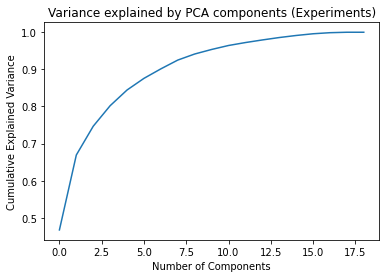

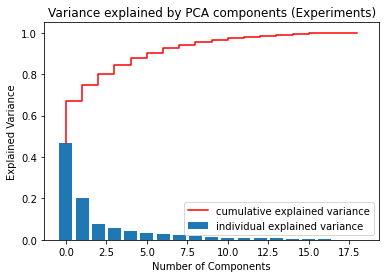

In [19]:
plot_pca_var(pca_e, tag="Experiments")

In [20]:
print(sum(pca_e.explained_variance_ratio_))
pca_e.explained_variance_ratio_[:2]

1.0000000000000002


array([0.46754345, 0.20182173])

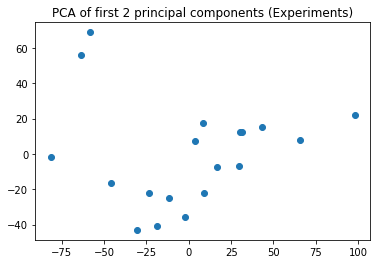

In [21]:
plot_pca_projection(exp_pca_projection, tag="Experiments")

In [22]:
# use first 3 principal components as a dataframe
principalDf_e123 = pd.DataFrame(data = exp_pca_projection[:,:3]
             , columns = ['pc1','pc2', 'pc3'])

principalDf_e123.head()

pc1        pc2        pc3
0  16.829293  -7.548968   5.742902
1  65.868625   8.061219 -26.997849
2   3.683640   7.379571  12.886854
3 -23.456367 -21.935079   5.977774
4 -63.802925  56.164052 -13.544186

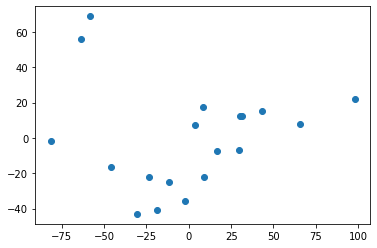

In [23]:
# replot for sanity check
plt.scatter(principalDf_e123.pc1, principalDf_e123.pc2)

In [24]:
# concat the principal components with Experiment info
final_df_e123 = pd.concat([principalDf_e123, df_means], axis=1)
final_df_e123.head()

pc1        pc2        pc3          exp_condition  EQU24_RS00005  \
0  16.829293  -7.548968   5.742902              LanzaTech      25.626702   
1  65.868625   8.061219 -26.997849                   MeOH      23.323155   
2   3.683640   7.379571  12.886854  NO3_lowO2_slow_growth      32.040358   
3 -23.456367 -21.935079   5.977774                   NoCu      44.338687   
4 -63.802925  56.164052 -13.544186            NoLanthanum      33.434023   

   EQU24_RS00010  EQU24_RS00015  EQU24_RS00020  EQU24_RS00025  EQU24_RS00030  \
0      55.711920      11.804042      76.880335      43.737438      27.940983   
1      18.905775      18.443916      18.257805      16.950643      12.367795   
2      43.646760      21.341623      62.257687      41.674925      31.911455   
3      59.619360      28.258717      56.808319      49.829406      38.384652   
4      43.679839      23.162675      57.287047      42.357072      41.931657   

   ...  EQU24_RS22110  EQU24_RS22115  EQU24_RS22120  EQU24_RS22125  \
0  ...    7420.641716      16.014544      15.947067      16.286482   
1  ...    1298.247682      15.614619      20.198066      25.994364   
2  ...    6497.858109      26.263485      28.935133      23.515245   
3  ...    8345.775345      43.055124      34.370565      44.409579   
4  ...    5085.627409      16.413284      35.578138      44.613117   

   EQU24_RS22130  EQU24_RS22135  EQU24_RS22140  EQU24_RS22145  EQU24_RS22150  \
0       9.514666      46.013885     354.315359     157.364073     571.458102   
1      20.950234      28.709983      93.606437     161.518124     496.980651   
2      26.422667      35.157264     178.986199     164.073806     433.428735   
3      34.591933      65.329879     253.598495     273.274694     731.042190   
4      43.191743      21.917260     109.773330      67.267718     211.565175   

   EQU24_RS22155  
0     613.084675  
1     280.334047  
2     493.885115  
3    1087.611126  
4     328.933746  

[5 rows x 4217 columns]

In [25]:
#final_df_e123.to_csv("experiments_with_3pc.tsv", sep='\t' ,index=False)

In [26]:
alt.Chart(final_df_e123, 
          title="PCA of 1st and 2nd Components",
          height=500,
          width=500
).mark_point(
    size=200
).encode(
    x='pc1:Q',
    y='pc2:Q',
    color=alt.Color('exp_condition:N',
                    scale=alt.Scale(scheme="sinebow"),
                    legend=alt.Legend(title="Experimental condition"),
                    sort=['NoLanthanum','NoCu','MeOH','lowCu','highO2_slow_growth','medCu','WithLanthanum','highCu','lowCH4']
                   ),
    tooltip=['exp_condition:N']
).interactive().configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

alt.Chart(...)

In [45]:
alt.Chart(final_df_e123, 
          title="PCA of 2 and 3 PCs (Experiments)",
          height=500,
          width=500
).mark_point(
    size=200
).encode(
    x='pc2:Q',
    y='pc3:Q',
    color=alt.Color('exp_condition:N',
                    scale=alt.Scale(scheme="sinebow"),
                    legend=alt.Legend(title="Experimental condition"),
                    sort=['NoLanthanum','NoCu','MeOH','lowCu','highO2_slow_growth','medCu','WithLanthanum','highCu','lowCH4']
                   ),
    tooltip=['exp_condition:N']
).interactive()

alt.Chart(...)

In [46]:
alt.Chart(final_df_e123, 
          title="PCA of 1 and 3 PCs (Experiments)",
          height=500,
          width=500
).mark_point(
    size=200
).encode(
    x='pc1:Q',
    y='pc3:Q',
    color=alt.Color('exp_condition:N',
                    scale=alt.Scale(scheme="sinebow"),
                    legend=alt.Legend(title="Experimental condition"),
                    sort=['NoLanthanum','NoCu','MeOH','lowCu','highO2_slow_growth','medCu','WithLanthanum','highCu','lowCH4']
                   ),
    tooltip=['exp_condition:N']
).interactive()

alt.Chart(...)

# try PCA 1) with all features and 2) with only CDSs

In [25]:
# # add extra info about the "system" I assigned certain genes and whether they have certain motifs
# mdf_piv['sys'] = mdf_piv['locus_tag'].apply(lambda x: 'other' if x not in sys_lookup else sys_lookup[x])
# #mdf_piv['m3_10_1_motif'] = mdf_piv['locus_tag'].apply(lambda x: x in m3_10_1_motif)

In [26]:
# # df with only cds's
# cdsdf = mdf_piv[mdf_piv['type']=="CDS"].reset_index(drop=True)

In [27]:

    

def run_pca_gene_stuff(df):
    '''
    maka a PCA projection of all the genes in the Df
    '''
    
    # get Standard Scaler version of the counts
    X = StandardScaler().fit_transform(df.select_dtypes(include=['float']))
    
    pca = PCA()
    pca_projection = pca.fit_transform(X)
    
    # draw basic matplotlib plots of variance explained and projections
    plot_pca_var(pca, tag='Genes')
    plot_pca_projection(pca_projection,tag="Genes")
    
    # combine pc vals back with original df
    # use first three principal components as a dataframe
    principalDf = pd.DataFrame(data = pca_projection[:,:3]
                 , columns = ['pc1', 'pc2','pc3'])

    # sanity replot that these components are the same
    plt.scatter(principalDf.pc1, principalDf.pc2)
    
    #final_df = pd.concat([principalDf, df], axis=1)
    # add pcs to original df
    df['pc1'] = pca_projection[:,0]
    df['pc2'] = pca_projection[:,1]
    df['pc3'] = pca_projection[:,2]
    
    # altair plot
    sel = alt.selection_multi(fields=['sys'], bind='legend')
    
    def pc_chart(x,y):
        ''' Same chart, change which pcs provided '''
        # pc1 and 2
        chart = alt.Chart(df,
                            title="PCA of PC 1 and 2 (Genes)",
                            height=500,
                            width=500
                           ).mark_circle().encode(
            x=x,
            y=y,
            color='sys:N',
            tooltip=['locus_tag:N', 'type:N','gene_symbol:N', 'product:N','sys:N'],
            opacity=alt.condition(sel, alt.value(1), alt.value(0.2)),
            size=alt.condition(sel, alt.value(200), alt.value(100)),
        ).add_selection(
            sel,
        ).interactive()
        
        return chart

    chart12 = pc_chart('pc1:Q', 'pc2:Q')
    chart23 = pc_chart('pc2:Q', 'pc3:Q')
    chart13 = pc_chart('pc1:Q', 'pc3:Q')
    
    
#     display(chart12)
#     display(chart23)
#     display(chart13)
    chart12.save("genes_pc12.html")
    chart23.save("genes_pc23.html")
    chart13.save("genes_pc13.html")
    
    return df
    

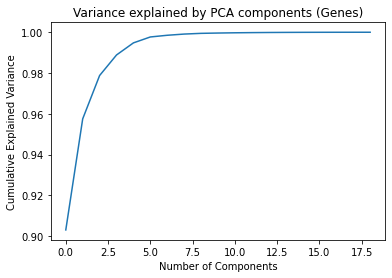

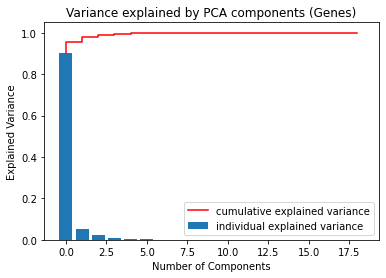

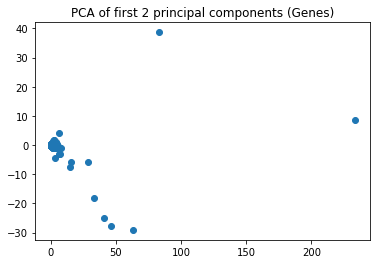

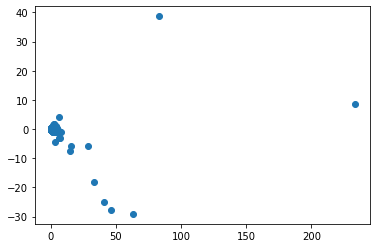

In [28]:
mdf_piv_pca = run_pca_gene_stuff(mdf_piv)